# Notebook for testing performance of Visual Recognition Custom Classifiers
[Watson Platform](https://www.ibm.com/watson/products-services/) AI capabilities are organized into 6 categories and available as API’s on IBM Cloud. You can train and adapt the Watson AI API's using a **supervised learning** approach. This begs the questions: "How many examples should we provide?" and "When is my solution ready for prime time?"

It is critical to understand that training a machine learning solution is an iterative process where it is important to continually improve the solution by providing new examples and measuring the performance of the trained solution. In this notebook, we show how you can compute important Machine Learning metrics (accuracy, precision, recall, confusion_matrix) to judge the performance of a custom Watson Visual Recognition model.

*__This notebook is based on the work by Joe Kozhaya and has been enhanced based on the work from this repo https://github.com/joe4k/wdcutils.__*

__Precision__: Proportion of information found that is correct or relevant. When testing "home room" image classification model on 1000 example images, 700 predicted as "kitchen". But only 500 of the were correct predictions. So your precision is 500/700 = 0.71. *Low Precision ⇒ Lots of False Positives*

__Recall__: Proportion of how many examples of interest the model has identified. Recall is a measure of how many true positives were found. If the "home room" model, say out of 100 bathroom images, predicted 90 (out of those 100), then recall is 90/100 = 0.9. *Low Recall ⇒ Lots of False Negatives*

__F1-Score__: F1 score conveys the balance between the precision and the recall. F1 score reaches its best value at 1 and worst score at 0. *Low F1 ⇒ Low P & R*

    f = 2 * (precision * recall) / (precision + recall)

__Confusion Matrix__ is commonly used to describe the performance of a classification model on a set of test data for which true values are known. Each row of the matrix represents the instances in a predicted class while each column represents the instances in an actual class (or vice versa).

<br> The notebook assumes you have already created a Watson [Visual Recognition](https://www.ibm.com/watson/developercloud/visual-recognition.html) instance and trained [custom classifiers](https://www.ibm.com/watson/developercloud/doc/visual-recognition/tutorial-custom-classifier.html). </br>
<br> To leverage this notebook, you need to provide the following information</br>
* Credentials for your Visual Recognition instance (apikey)
* id for your trained classifier (this is returned when you train your Visual Recognition custom classifier)
* csv file with your test images (paths to images on your local disk) and corresponding class labels (image, class are the columns)
* results csv file to write the results to (true vs. predicted class labels)
* csv file to write confusion matrix to

Note that the input test csv file should have a header with the fields **image** and **class**. 

In [1]:
# Only run this the first time if pandas_ml is not installed on your machine
!pip install pandas_ml

# Install latest version of watson_developer_cloud Python SDK
!pip install --upgrade watson-developer-cloud

  Using cached https://files.pythonhosted.org/packages/c1/28/19289aabaecac9bd7ea34c43310fa16bbdda818e1f635747e81b376526ca/pandas_ml-0.5.0.tar.gz
  Using cached https://files.pythonhosted.org/packages/82/62/e9058dc7f4d3be74d1111c14bc69a6edb8aeefbd4f6974f151d9d724fe04/pandas-0.22.0-cp27-cp27m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/c5/db/e56e6b4bbac7c4a06de1c50de6fe1ef3810018ae11732a50f15f62c7d050/enum34-1.1.6-py2-none-any.whl
    100% |████████████████████████████████| 4.7MB 1.9MB/s ta 0:00:01
matplotlib 1.3.1 requires nose, which is not installed.
matplotlib 1.3.1 requires tornado, which is not installed.
  Found existing installation: numpy 1.8.0rc1
Cannot uninstall 'numpy'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.
You are using pip version 10.0.0, however version 10.0.

Cannot uninstall 'six'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.
You are using pip version 10.0.0, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
#Import utilities
import json
import csv
import sys
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas_ml
from pandas_ml import ConfusionMatrix
from watson_developer_cloud import VisualRecognitionV3

Provide the path to the parms file which includes credentials to access your VR service as well as the input
test csv file and the output csv files to write the output results to.

In [3]:
# Parameters that are needed for the evaluation script to run

url='https://gateway-a.watsonplatform.net/visual-recognition/api'
apikey='YOUR API KEY'
vr_id='YOUR MODEL ID'
test_csv_file='../test/files.csv'
results_csv_file='../test/results.csv'
confmatrix_csv_file='../test/confusionmatrix.csv'

# Create an object for your Visual Recognition instance
visual_recognition = VisualRecognitionV3('2018-03-19', api_key=apikey)

Define useful methods to classify using custom VR classifier.

In [4]:
# Given an image and a pointer to VR instance and classifierID, get back VR response
def getVRresponse(vr_instance,classifierID,image_path):
    with open(image_path, 'rb') as image_file:
        parameters = json.dumps({'threshold':0.01, 'classifier_ids': [classifierID]})
       #parameters = json.dumps({'threshold':0.01, 'classifier_ids': ['travel_1977348895','travel_2076475268','default']}) 
        image_results = vr_instance.classify(images_file=image_file,
                                             parameters = parameters)
        # For our purposes, we assume each call is to classify one image
        # Although the Visual Recognition classify endpoint accepts as input
        # a .zip file, we need each image to be labeled with the correct class
        classList = []
        for classifier in image_results['images'][0]['classifiers']:
            if classifier['classifier_id'] == vr_id:
                classList = classifier['classes']
                break
        # Sort the returned classes by score
        #print("classList: ", classList)
        sorted_classList = sorted(classList, key=lambda k: k.get('score', 0), reverse=True)
        #print("sortedList: ", sorted_classList)
    return sorted_classList

# Process multiple images (provided via csv file) in batch. Effectively, read the csv file and for each image
# utterance, get VR response. Aggregate and return results.
def batchVR(vr_instance,classifierID,csvfile):
    test_classes=[]
    vr_predict_classes=[]
    vr_predict_confidence=[]
    images=[]
    i=0
    with open(csvfile, 'r') as csvfile:
        csvReader=csv.DictReader(csvfile)
        for row in csvReader:
            test_classes.append(row['class'])
            vr_response = getVRresponse(vr_instance,classifierID,row['image'])
            vr_predict_classes.append(vr_response[0]['class'])
            vr_predict_confidence.append(vr_response[0]['score'])
            images.append(row['image'])
            i = i+1
            if(i%250 == 0):
                print("")
                print("Processed ", i, " records")
            if(i%10 == 0):
                sys.stdout.write('.')
        print("")
        print("Finished processing ", i, " records")
    return test_classes, vr_predict_classes, vr_predict_confidence, images

# Plot confusion matrix as an image
def plot_conf_matrix(conf_matrix):
    plt.figure()
    plt.imshow(conf_matrix)
    plt.show()

# Print confusion matrix to a csv file
def confmatrix2csv(conf_matrix,labels,csvfile):
    with open(csvfile, 'w') as csvfile:
        csvWriter = csv.writer(csvfile)
        row=list(labels)
        row.insert(0,"")
        csvWriter.writerow(row)
        for i in range(conf_matrix.shape[0]):
            row=list(conf_matrix[i])
            row.insert(0,labels[i])
            csvWriter.writerow(row)
            

Call Visual Recognition on the specified csv file and collect results.

In [6]:
test_classes,vr_predict_classes,vr_predict_conf,images=batchVR(visual_recognition,vr_id,test_csv_file)

..
Finished processing  29  records


In [7]:
# print results to csv file including original text, the correct label, 
# the predicted label and the confidence reported by NLC.
csvfileOut=results_csv_file
with open(csvfileOut, 'w') as csvOut:
    outrow=['image','true class','VR Predicted class','Confidence']
    csvWriter = csv.writer(csvOut,dialect='excel')
    csvWriter.writerow(outrow)
    for i in range(len(images)):
        outrow=[images[i],test_classes[i],vr_predict_classes[i],str(vr_predict_conf[i])]
        csvWriter.writerow(outrow)

In [8]:
# Compute confusion matrix
labels=list(set(test_classes))
vr_confusion_matrix = confusion_matrix(test_classes, vr_predict_classes, labels)
vrConfMatrix = ConfusionMatrix(test_classes, vr_predict_classes)

In [9]:
# Print out confusion matrix with labels to csv file
confmatrix2csv(vr_confusion_matrix,labels,confmatrix_csv_file)

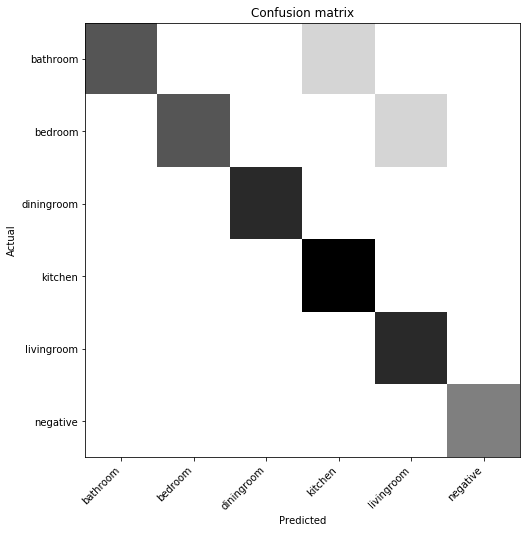

In [20]:
%matplotlib inline
vrConfMatrix.plot()

In [16]:
# Compute accuracy of classification
acc=accuracy_score(test_classes, vr_predict_classes)
print('Classification Accuracy: ', acc)

Classification Accuracy:  0.9310344827586207


In [12]:
# print precision, recall and f1-scores for the different classes
print(classification_report(test_classes, vr_predict_classes, labels=labels))

             precision    recall  f1-score   support

    kitchen       0.86      1.00      0.92         6
    bedroom       1.00      0.80      0.89         5
   bathroom       1.00      0.80      0.89         5
 diningroom       1.00      1.00      1.00         5
   negative       1.00      1.00      1.00         3
 livingroom       0.83      1.00      0.91         5

avg / total       0.94      0.93      0.93        29



In [13]:
#Optional if you would like each of these metrics separately
#[precision,recall,fscore,support]=precision_recall_fscore_support(test_classes, vr_predict_classes, labels=labels)
#print("precision: ", precision)
#print("recall: ", recall)
#print("f1 score: ", fscore)
#print("support: ", support)